In [96]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GroupKFold
import eli5

In [32]:
df_train = pd.read_hdf("../input/energy_train.h5")
df_test = pd.read_hdf("../input/energy_test.h5")

df_all = pd.concat([df_train, df_test])
df_all["date"] = pd.to_datetime(df_all["date"])

df_all.shape

(35252, 3)

In [33]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35252 entries, 24 to 35251
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      35252 non-null  int64         
 1   date    35252 non-null  datetime64[ns]
 2   value   26517 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.1 MB


In [45]:
df_all.sample(20)

,id,date,value,day,month,year,hour,dayofweek,dayofyear,weekofyear,is_winter,is_summer,is_day,is_night,is_lockdown,d+m,is_holiday
date,,,,,,,,,,,,,,,,,
2020-03-22 22:00:00,18068,2020-03-22 22:00:00,17421.400,22,3,2020,22,6,82,12,0.0,0.0,1.0,0.0,1.0,22_3,0.0
2020-09-26 11:00:00,22568,2020-09-26 11:00:00,20094.150,26,9,2020,11,5,270,39,0.0,0.0,1.0,0.0,1.0,26_9,0.0
2019-02-06 00:00:00,8207,2019-02-06 00:00:00,19776.875,6,2,2019,0,2,37,6,1.0,0.0,0.0,1.0,0.0,6_2,0.0
2019-06-13 13:00:00,11267,2019-06-13 13:00:00,NaN,13,6,2019,13,3,164,24,0.0,1.0,1.0,0.0,0.0,13_6,0.0
2018-04-23 22:00:00,1293,2018-04-23 22:00:00,20635.325,23,4,2018,22,0,113,17,0.0,0.0,1.0,0.0,0.0,23_4,0.0
2022-02-05 15:00:00,34499,2022-02-05 15:00:00,20949.425,5,2,2022,15,5,36,5,1.0,0.0,1.0,0.0,0.0,5_2,0.0
2022-02-24 13:00:00,34953,2022-02-24 13:00:00,NaN,24,2,2022,13,3,55,8,1.0,0.0,1.0,0.0,0.0,24_2,0.0
2020-08-25 18:00:00,21807,2020-08-25 18:00:00,20229.538,25,8,2020,18,1,238,35,0.0,1.0,1.0,0.0,1.0,25_8,0.0
2020-07-08 05:00:00,20642,2020-07-08 05:00:00,NaN,8,7,2020,5,2,190,28,0.0,1.0,0.0,1.0,1.0,8_7,0.0


In [35]:
df_all.date.min(), df_all.date.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2022-03-08 23:00:00'))

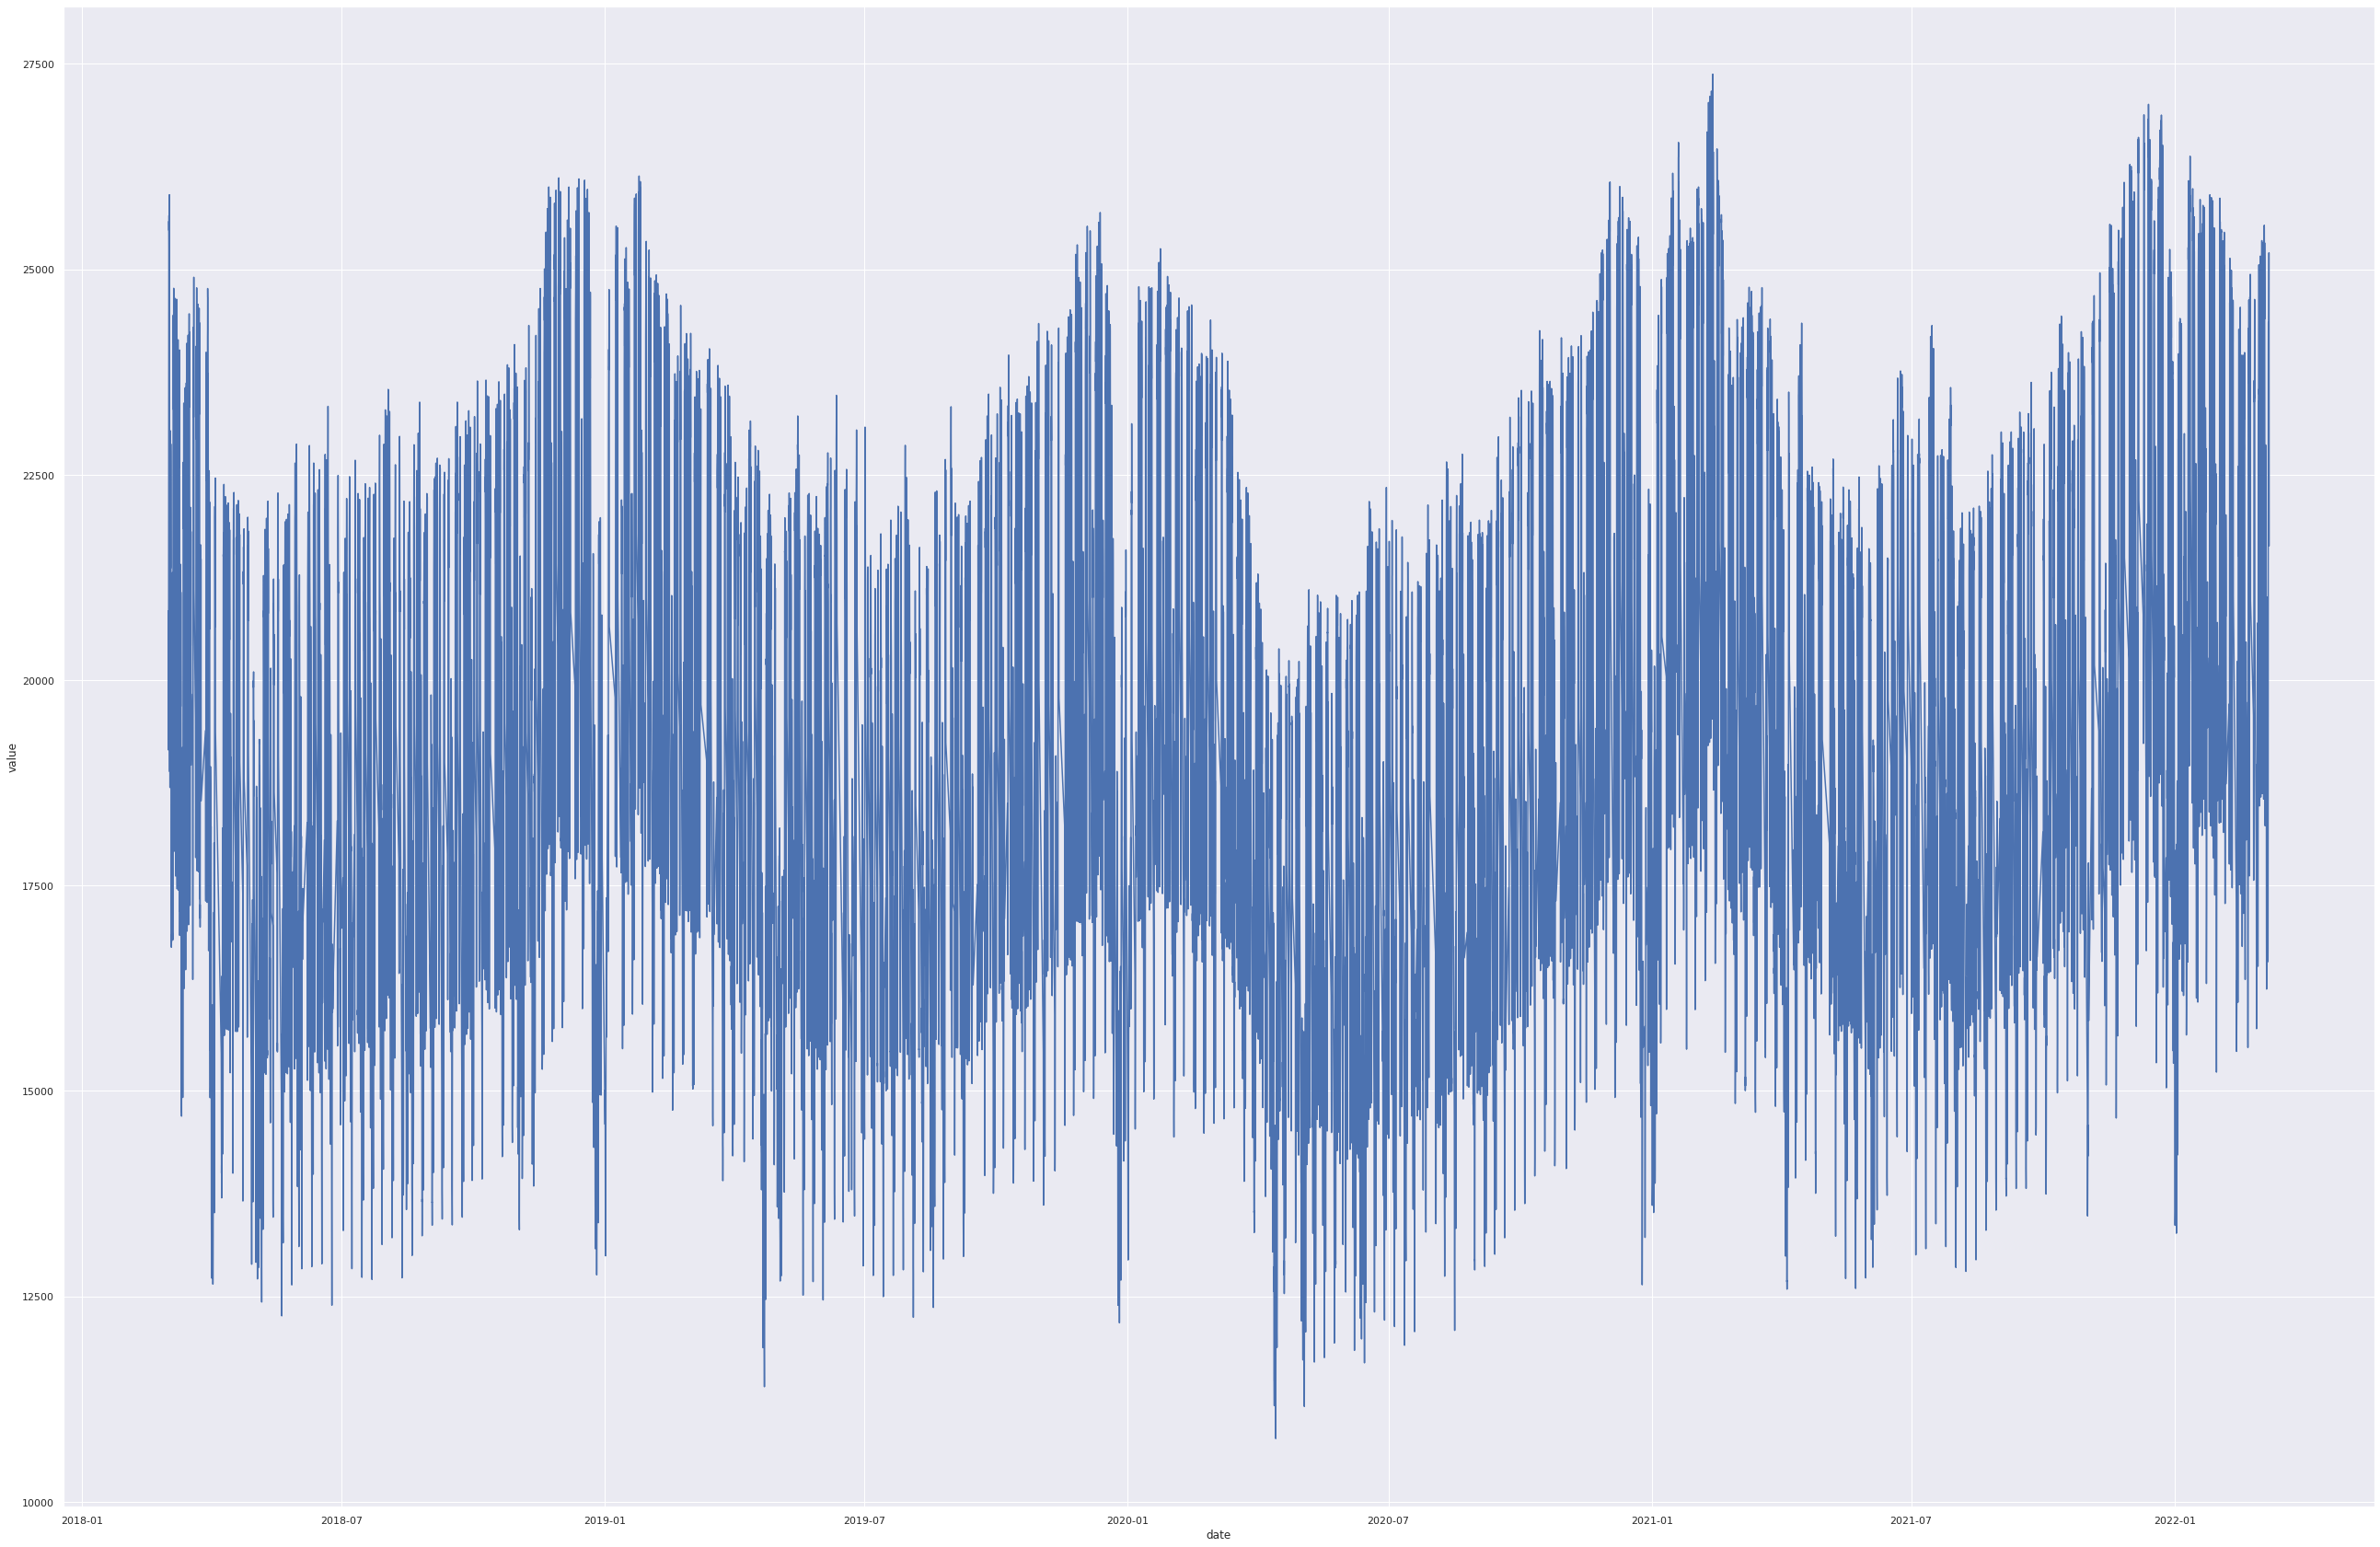

In [36]:
plt.figure(figsize=(45, 30))
sns.lineplot(x='date', y='value', data=df_all);

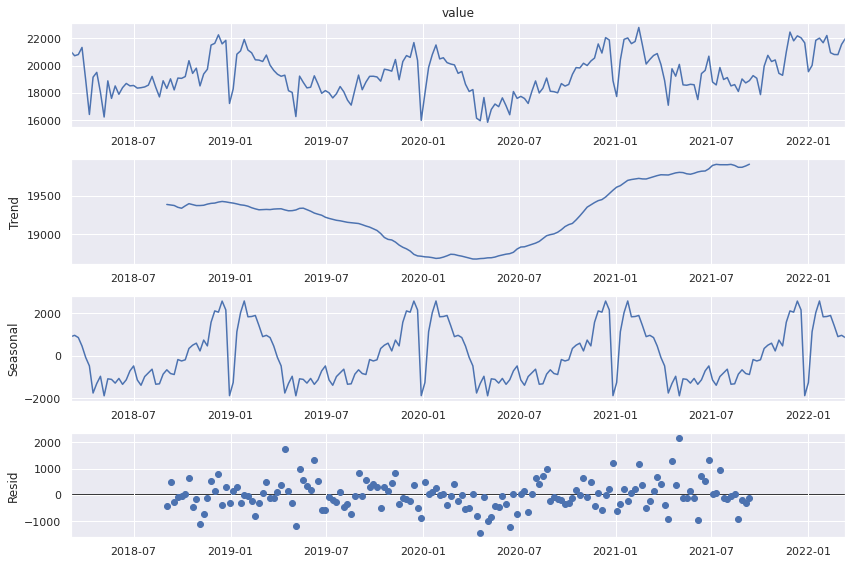

In [48]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
df_0_1m = df_all.resample('1W').mean()
decomposition = sm.tsa.seasonal_decompose(df_0_1m.value, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

# Feature engineering

In [37]:
def feature_engineering(df):
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["hour"] = df["date"].dt.hour
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    df["weekofyear"] = df["date"].dt.weekofyear
    
    
    df.index = df["date"]
    df_train = df[ df.value.notnull() ]
    

    
    return df
    
df_all = feature_engineering(df_all.copy())

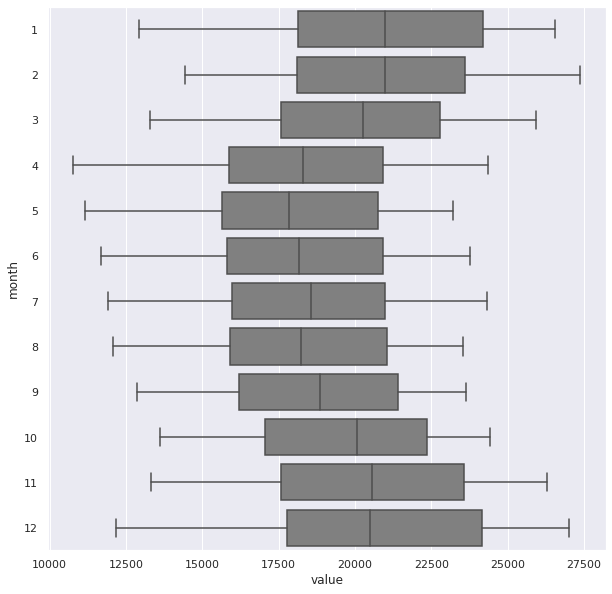

In [38]:
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.boxplot(x="value", y="month", data=df_all, orient='h', color = 'gray')

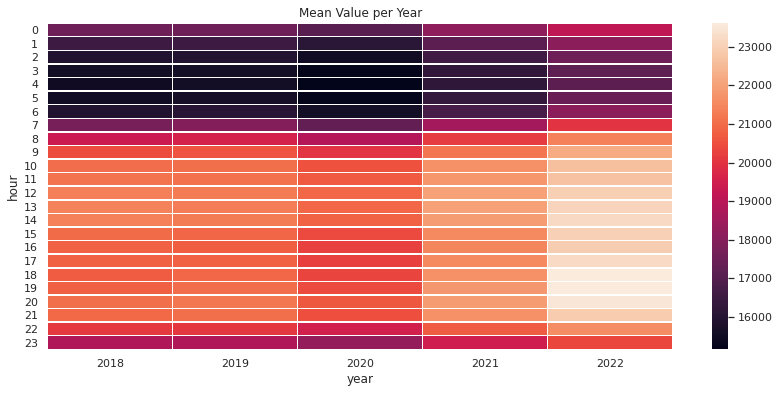

In [39]:
plt.figure(figsize=(14,6))
sns.heatmap(df_all.groupby(['hour', 'year']).aggregate('value').mean().reset_index().pivot('hour', 'year', 'value'), linewidths=.5)
plt.title('Mean Value per Year');

In [76]:
df_all.loc[(df_all['month'] == 10) | (df_all['month'] == 11) | (df_all['month'] == 12) | (df_all['month'] == 1) | (df_all['month'] == 2), 'is_winter'] = 1
df_all.loc[df_all['is_winter'].isnull(), 'is_winter'] = 0

df_all.loc[(df_all['month'] == 6) | (df_all['month'] == 7) | (df_all['month'] == 8) , 'is_summer'] = 1
df_all.loc[df_all['is_summer'].isnull(), 'is_summer'] = 0

df_all.loc[(df_all['hour'] >=7) & (df_all['hour'] <= 22)  , 'is_day'] = 1
df_all.loc[df_all['is_day'].isnull(), 'is_day'] = 0

df_all.loc[(df_all['hour'] >22) & (df_all['hour'] <= 24) | (df_all['hour'] >=0) & (df_all['hour'] <= 6)  , 'is_night'] = 1
df_all.loc[df_all['is_night'].isnull(), 'is_night'] = 0

df_all.loc[(df_all['date'] > '2020-03-13 00:00:00') & (df_all['date'] < '2020-12-31 00:00:00') , 'is_lockdown'] = 1
df_all.loc[df_all['is_lockdown'].isnull(), 'is_lockdown'] = 0

df_all["d+m"] = df_all["day"].astype(str) + "_" + df_all['month'].astype(str)
df_all.loc[(df_all['d+m'] == '23_12') | (df_all['d+m'] == '24_12') |  (df_all['d+m'] == '25_12') | (df_all['d+m'] == '26_12') | (df_all['d+m'] == '31_12') | (df_all['d+m'] == '1_1') | (df_all['d+m'] == '6_1')| (df_all['d+m'] == '1_5') | (df_all['d+m'] == '2_5') | (df_all['d+m'] == '3_5') | (df_all['d+m'] == '1_11') | (df_all['d+m'] == '11_11')  , 'is_holiday'] = 1
df_all.loc[(df_all['date'] == '2018-04-01')|(df_all['date'] == '2018-04-02')|(df_all['date'] == '2019-04-21')|(df_all['date'] == '2019-04-22')|(df_all['date'] == '2020-04-13')|(df_all['date'] == '2020-04-12')|(df_all['date'] == '2021-04-04')|(df_all['date'] == '2018-03-31')| (df_all['date'] == '2019-04-20')|(df_all['date'] == '2020-04-11')|(df_all['date'] == '2021-04-03')|(df_all['date'] == '2018-05-20')|(df_all['date'] == '2019-06-09')|(df_all['date'] == '2020-06-11')|(df_all['date'] == '2021-06-03'), 'is_holiday'] = 1
df_all.loc[df_all['is_holiday'].isnull(), 'is_holiday'] = 0

df_all.loc[(df_all['day'] >=5), 'is_weekend'] = 1
df_all.loc[df_all['is_weekend'].isnull(), 'is_weekend'] = 0

df_all.loc[(df_all['day'] <5) & df_all['is_holiday']==0, 'is_working_day'] = 1
df_all.loc[df_all['is_working_day'].isnull(), 'is_working_day'] = 0


df_all.loc[(df_all['date'] < '2019-12-01 00:00:00') , 'trend1'] = 1
df_all.loc[df_all['trend1'].isnull(), 'trend1'] = 0

df_all.loc[(df_all['date'] >= '2019-12-01 00:00:00') & (df_all['date'] <= '2020-07-01 00:00:00') , 'trend2'] = 1
df_all.loc[df_all['trend2'].isnull(), 'trend2'] = 0

df_all.loc[(df_all['date'] > '2020-07-01 00:00:00') , 'trend3'] = 1
df_all.loc[df_all['trend3'].isnull(), 'trend3'] = 0

df_all['expensive_energy'] = df_all['hour'].map(lambda x: 1 if ((x >=6) & (x<13)) | ((x >=15) & (x<22)) else 0 )

In [51]:
df_all['value_shift_24'] =  df_all['value'].shift(24) #bo o 24h czyli 1 dzien

In [79]:
df_all_agg = df_all.resample('1h').mean()

In [82]:
df_all['hour_5'] = df_all_agg.hour.isin([5])
df_all['hour_2'] = df_all_agg.hour.isin([2])
df_all['hour_4'] = df_all_agg.hour.isin([4])
df_all['hour_23'] = df_all_agg.hour.isin([23])
df_all['hour_0'] = df_all_agg.hour.isin([0])
df_all['hour_1'] = df_all_agg.hour.isin([1])
df_all['hour_3'] = df_all_agg.hour.isin([3])
df_all['hour_6'] = df_all_agg.hour.isin([6])
df_all['hour_7'] = df_all_agg.hour.isin([7])
df_all['hour_8'] = df_all_agg.hour.isin([8])
df_all['hour_9'] = df_all_agg.hour.isin([9])
df_all['hour_10'] = df_all_agg.hour.isin([10])
df_all['hour_11'] = df_all_agg.hour.isin([11])
df_all['hour_12'] = df_all_agg.hour.isin([12])
df_all['hour_13'] = df_all_agg.hour.isin([13])
df_all['hour_14'] = df_all_agg.hour.isin([14])
df_all['hour_15'] = df_all_agg.hour.isin([15])
df_all['hour_16'] = df_all_agg.hour.isin([16])
df_all['hour_17'] = df_all_agg.hour.isin([17])
df_all['hour_18'] = df_all_agg.hour.isin([18])
df_all['hour_19'] = df_all_agg.hour.isin([19])
df_all['hour_20'] = df_all_agg.hour.isin([20])
df_all['hour_21'] = df_all_agg.hour.isin([21])
df_all['hour_22'] = df_all_agg.hour.isin([22])

In [87]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35252 entries, 2018-03-02 00:00:00 to 2022-03-08 23:00:00
Data columns (total 48 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                35252 non-null  int64         
 1   date              35252 non-null  datetime64[ns]
 2   value             26517 non-null  float64       
 3   day               35252 non-null  int64         
 4   month             35252 non-null  int64         
 5   year              35252 non-null  int64         
 6   hour              35252 non-null  int64         
 7   dayofweek         35252 non-null  int64         
 8   dayofyear         35252 non-null  int64         
 9   weekofyear        35252 non-null  int64         
 10  is_winter         35252 non-null  float64       
 11  is_summer         35252 non-null  float64       
 12  is_day            35252 non-null  float64       
 13  is_night          35252 non-null  float64

CPU times: user 1.27 s, sys: 173 ms, total: 1.45 s
Wall time: 1.27 s


(46.5, -0.5)

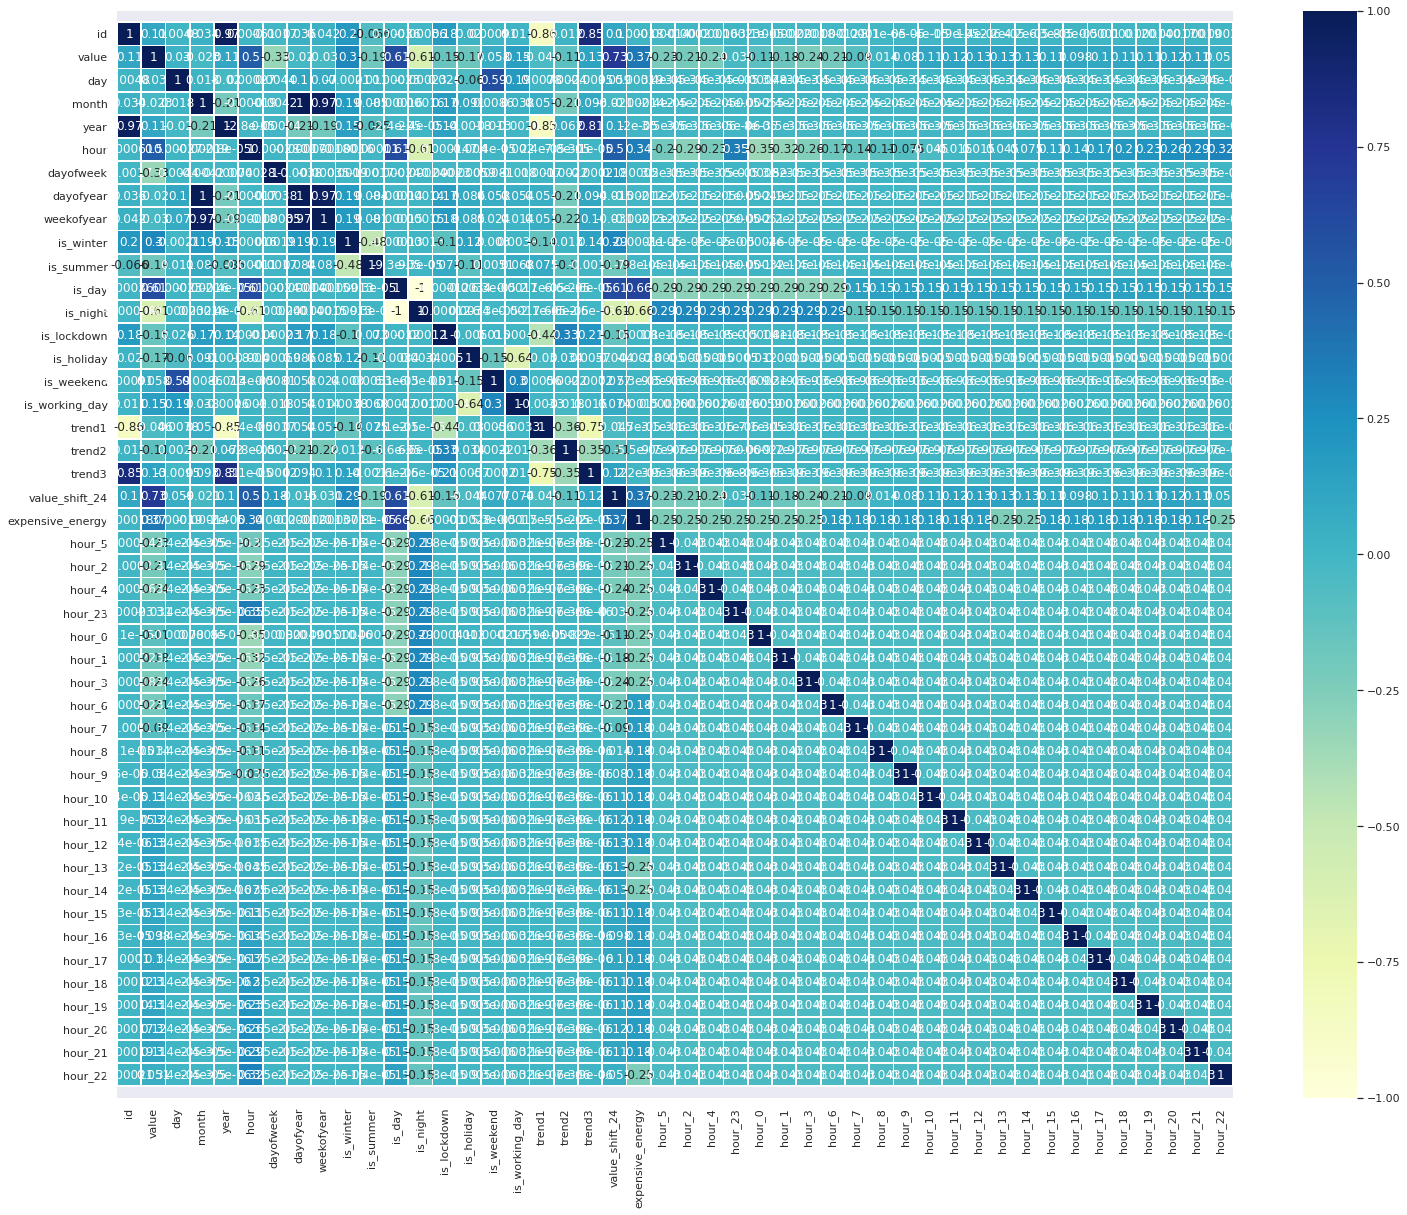

In [84]:
#heatmap
plt.rcParams['figure.figsize']=(25,20)
%time ax = sns.heatmap(df_all.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Create model

In [88]:
def get_feats(df, black_list=[ 'id', 'value', "value_shift_24"]):
    num_feats = df.select_dtypes(include = [np.int64, np.float64, np.bool]).columns
    return [x for x in num_feats if x not in black_list]

feats = get_feats(df_all)
feats

['day',
 'month',
 'year',
 'hour',
 'dayofweek',
 'dayofyear',
 'weekofyear',
 'is_winter',
 'is_summer',
 'is_day',
 'is_night',
 'is_lockdown',
 'is_holiday',
 'is_weekend',
 'is_working_day',
 'trend1',
 'trend2',
 'trend3',
 'expensive_energy',
 'hour_5',
 'hour_2',
 'hour_4',
 'hour_23',
 'hour_0',
 'hour_1',
 'hour_3',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22']

In [89]:
df_train = df_all[ df_all["value"].notnull() ]
df_test = df_all[ df_all["value"].isnull() ]

X_train = df_train[feats].values
y_train = np.log(df_train["value"].values)
X_test  = df_test[feats].values

In [64]:
model_xgb = xgb.XGBRegressor(max_depth=15, learning_rate=0.12, n_estimators=500, random_state=2014)
model_xgb.fit(X_train, y_train)
y_pred_log = model_xgb.predict(X_train)
mean_absolute_error(np.exp(y_train), np.exp(y_pred_log))

28.849390752276776

In [90]:
xgb_params = {
        'max_depth': 14, 
        'n_estimators': 900,
        'learning_rate': 0.17, 
        'subsample': 0.5, 
        'random_state':0, 
        'colsample_bytree': 0.9
}

In [91]:
cv = GroupKFold(n_splits=10)
model = xgb.XGBRegressor(**xgb_params)
scores = cross_val_score(model, X_train, y_train, groups=df_train["day"], cv=cv, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

(-0.0221821976048727, 0.004778725173274965)

In [92]:
model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [97]:
eli5.show_weights(model, feature_names=feats)

Weight,Feature
0.3845,is_winter
0.3570,is_day
0.0627,is_holiday
0.0594,is_working_day
0.0263,hour
0.0257,hour_0
0.0168,dayofweek
0.0158,weekofyear
0.0110,trend2
0.0068,is_lockdown


In [94]:
#save predictions
y_pred_test = np.exp(model.predict(X_test))
df_test['value'] = y_pred_test
df_test[ ['id', 'value'] ].to_csv('../output/model_final?v5.csv', index=False)

<ipython-input-94-98f1853378b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['value'] = y_pred_test


# Hyperopt

In [70]:
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3) #dzielimy dane 

In [71]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_squared_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

100%|██████████| 30/30 [01:17<00:00,  2.59s/trial, best loss: 0.00044096564651955575]
The best params:  {'x_colsample_bytree': 0.9239405536858496, 'x_learning_rate': 0.1705764089479642, 'x_max_depth': 14.0, 'x_min_child_weight': 4.0, 'x_random_state': 6600.0, 'x_reg_alpha': 1.0170646421266616, 'x_reg_lambda': 0.9093456887725662, 'x_subsample': 0.7870490236069128}


In [72]:
trials.best_trial

{'state': 2,
 'tid': 25,
 'spec': None,
 'result': {'loss': 0.00044096564651955575, 'status': 'ok'},
 'misc': {'tid': 25,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [25],
   'x_learning_rate': [25],
   'x_max_depth': [25],
   'x_min_child_weight': [25],
   'x_random_state': [25],
   'x_reg_alpha': [25],
   'x_reg_lambda': [25],
   'x_subsample': [25]},
  'vals': {'x_colsample_bytree': [0.9239405536858496],
   'x_learning_rate': [0.1705764089479642],
   'x_max_depth': [14.0],
   'x_min_child_weight': [4.0],
   'x_random_state': [6600.0],
   'x_reg_alpha': [1.0170646421266616],
   'x_reg_lambda': [0.9093456887725662],
   'x_subsample': [0.7870490236069128]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 4, 3, 18, 12, 46, 577000),
 'refresh_time': datetime.datetime(2022, 4, 3, 18, 12, 49, 619000)}